# Simulación de Stock

Sebastián P. Pincheira\
Desarrollador Ocho Fuegos\
sebastian.pincheira@ug.uchile.cl\
+56 9 8918 6914

## Modelamiento

In [27]:
import numpy as np
import scipy.stats as stats
from scipy.integrate import cumulative_trapezoid
import matplotlib.pyplot as plt
import pandas as pd
import random
from tqdm import tqdm

import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'src', 'backend')))

from classes import Packing, Material

SEED = 115

np.random.seed(SEED)
random.seed(SEED)

Modelamos velocidad de entrada de KG a un packing mediante una *bump function*. En este caso utilizamos
$$V(t)=\begin{cases}
\exp\left(1-\left(\frac{9}{9 - t^2}\right)^{20}\right) & |t|\leq 1\\
0 & |t|> 1
\end{cases}$$

In [28]:
test = False

if not test:

    def bump_function(x):
            # Ensure `x` is an array, even if it is a single number
            x = np.asarray(x)
            result = np.zeros_like(x)
            mask = np.abs(x) < 1
            result[mask] = np.exp(-1 / (1 - (x[mask] / 3) ** 2) ** 20) * np.exp(1)
            return (
                result if result.size > 1 else result.item()
            )  # Return scalar if input was scalar

else:
    def bump_function(x):
        # Ensure `x` is an array, even if it's a single number
        x = np.asarray(x)
        result = np.zeros_like(x)  # Initialize with zeros
        mask = np.abs(x) <= 1      # Check where x is within [-1, 1]
        result[mask] = 1           # Set values in [-1, 1] to 1
        return result if result.size > 1 else result.item()  # Return scalar if input was scalar

def noisy_bump(x, length_scale=0.1):
    
    def smooth_noise(x, length_scale=0.1):
        # Ensure `x` is an array, even if it is a single number
        x = np.asarray(x)
        if np.ndim(x) == 0:  # If x is a scalar
            x = np.array([x])
        n_points = len(x)

        # Define covariance matrix using the Gaussian kernel
        covariance_matrix = np.exp(-0.5 * (np.subtract.outer(x, x) / length_scale) ** 2)

        # Generate smooth noise as a sample from a multivariate normal distribution
        noise = np.random.multivariate_normal(
            mean=np.zeros(n_points), cov=covariance_matrix
        )
        return (
            noise if noise.size > 1 else noise.item()
        )  # Return scalar if input was scalar

    f = bump_function(x)
    wide_noise = smooth_noise(1/1000 * x, length_scale) / 10
    medium_noise = smooth_noise(1/2 * x, length_scale) / 10
    narrow_noise = smooth_noise(20 * x, length_scale) / 10
    return abs(f + (wide_noise + medium_noise + narrow_noise) * np.exp(-((2 * x) ** 2)))


def descrete_noisy_bump(support: int, maximum: float, length_scale=0.1, num_points=100):
    def scaled_noisy_bump(support: int, maximum: float, length_scale=0.1):
        """
        Function that returns a bump function supported at `support` and scaled to have maximum value `maximum`.
        The center of the bump is at the center of the support.
        """
        def fun(x):
            return maximum * noisy_bump(
                (x - support / 2) / (support / 2),
                length_scale,
            )
        return fun

    fun = scaled_noisy_bump(support, maximum, length_scale)
    integrals = np.zeros(support)

    # Calculate the integral from i to i + 1 for each i in the range of support
    for i in range(support):
        # Define points for integration
        x_values = np.linspace(i, i + 1, num_points)
        y_values = fun(x_values)
        
        # Use the trapezoidal rule to approximate the integral over [i, i+1]
        integrals[i] = np.trapz(y_values, x_values)

    return integrals

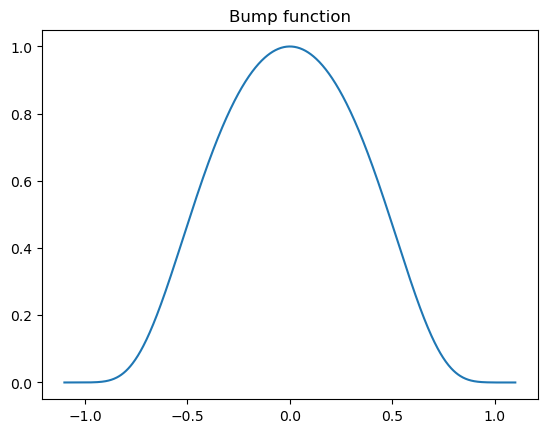

In [29]:
# plot bump function

x = np.linspace(-1.1, 1.1, 1000)
y = bump_function(x)
plt.plot(x, y)
plt.title("Bump function")
plt.show()

Luego re-escalamos y transladamos para tener una velocidad de producción máxima de $100000$ kg/dias y que la función tenga soporte en $[0,60]$, la duración de la temporada. Agregamos, además, ruido y calculamos la producción diaria.

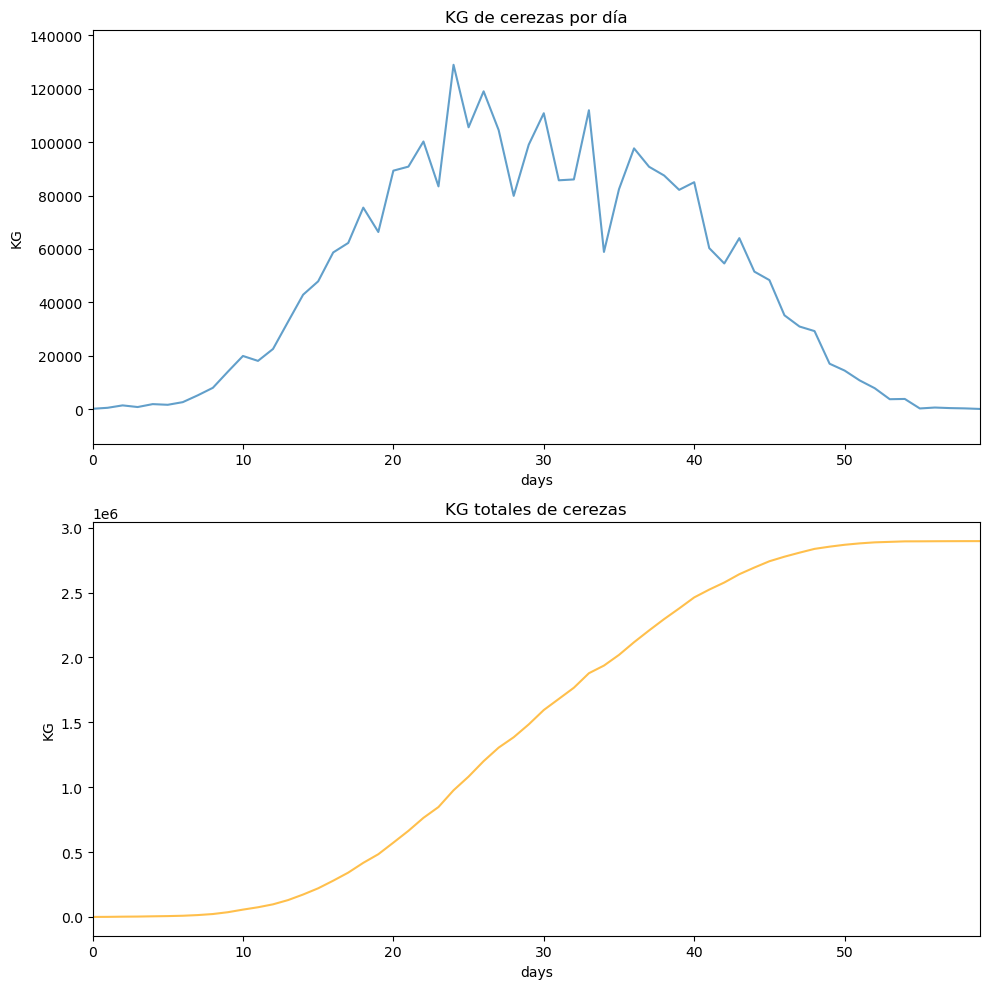

In [30]:
# Parameters
support = 60
maximum = 100_000

# Generate data
daily_production = descrete_noisy_bump(support, maximum)
cumulative_production = np.cumsum(daily_production)

# Define the x-axis range for days
days = np.arange(support)

# Plot the original `speed_of_production` function
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot the daily production
axs[0].plot(days, daily_production, alpha=0.7)
axs[0].set_xlabel("days")
axs[0].set_ylabel("KG")
axs[0].set_title("KG de cerezas por día")
axs[0].set_xlim(0, support - 1)
largest_value = max(daily_production)
axs[0].set_ylim(0 - 0.1 * largest_value, largest_value * 1.1)

# Plot the cumulative production
axs[1].plot(days, cumulative_production, color="orange", alpha=0.7)
axs[1].set_xlabel("days")
axs[1].set_ylabel("KG")
axs[1].set_title("KG totales de cerezas")
axs[1].set_xlim(0, support - 1)

plt.tight_layout()
plt.show()


Ahora simulamos las predicciones de producción semanal del campo calculando la producción semanal real y agregando ruido Gaussiano; la cantidad estimada es una variable aleatoria con distribución normal, centrada en el valor real con desviación estándard de $15\%$ el valor real. Se asume que el sistema comienza un jueves ($0$ es jueves), el día en el que llega la estimación de producción de la semana siguiente.

In [31]:
# Define the range based on the given support
max_multiple = support // 7
weeks = np.linspace(0, max_multiple * 7, max_multiple + 1, dtype=int) + 4 # +4 because 0 is a thusrday so the first week starts on a monday (4)

# Integrate over each weekly interval and add noise
weekly_boxes = np.zeros(len(weeks))
for i, week in enumerate(weeks):
    start = week
    end = week + 7
    weekly_boxes[i] = np.sum(daily_production[start:end])


In [32]:
# Add noise to the integrated values
mean = 0
std_dev = 1
noise = np.random.normal(mean, std_dev, size=weekly_boxes.shape)

error = 0.15
weekly_boxes_estimation = np.maximum(weekly_boxes + noise * error * weekly_boxes, 0)

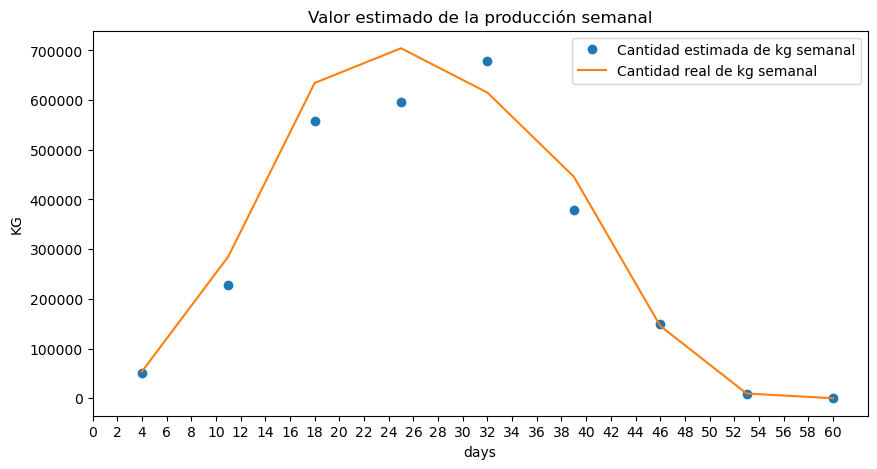

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(weeks, weekly_boxes_estimation, "o", label="Cantidad estimada de kg semanal")
plt.plot(weeks, weekly_boxes, label="Cantidad real de kg semanal")
plt.legend()
even_days = np.arange(0, support + 1, 2)
plt.xticks(even_days)
plt.xlabel("days")
plt.ylabel("KG")
plt.title("Valor estimado de la producción semanal")
plt.show()

Obtenemos información inicial de los materiales. El DELIVERY TIME es un número aleatorio del 1 al 5 (distribución uniforme).

In [34]:
# Create a dummy stock data

item_names = [
    "MCER017",
    "MCER018",
    "MCER020",
    "MCER021",
    "MCER022",
    "MCER026",
    "MCER027",
    "MCER028",
    "MCER029",
    "MCER030",
    "MCER031",
    "MCER032",
    "MCER033",
    "MCER034",
    "MCER035",
    "MCER036",
    "MCER037",
    "MCER038",
    "MCER039",
    "MCER040",
    "MCER041",
    "MCER043",
    "MCER046",
    "MCER047",
    "MCER051",
    "MCER057",
    "MCER067",
]

ammount_of_items: int = len(item_names)

print("Item ammount: ", ammount_of_items)

items: list[str] = item_names
stock: list[int] = [0 for i in range(len(items))]
emergency_stock: list[int] = [0 for i in range(len(items))]
delivery_time: list[int] = [random.randint(1, 5) for i in range(len(items))]

stock_data: pd.DataFrame = pd.DataFrame(
    {
        "CODIGO": items,
        "STOCK": stock,
        "EMERGENCY STOCK": emergency_stock,
        "DELIVERY TIME": delivery_time,
    }
)



kg = pd.DataFrame(
    {
        "PACKING": ["packing"],
        "KG": [0],
    }
)

packings_dict = {"packing": stock_data}

print(stock_data.head())
print()
print(kg.head())

Item ammount:  27
    CODIGO  STOCK  EMERGENCY STOCK  DELIVERY TIME
0  MCER017      0                0              3
1  MCER018      0                0              2
2  MCER020      0                0              1
3  MCER021      0                0              5
4  MCER022      0                0              1

   PACKING  KG
0  packing   0


Modelamos la transformación de KG a tipos de caja de manera aleatoria; la cantidad de cajas que hacen $10$ KG de fruta es una variable aleatoria uniforme sobre los números enteros del 1 al 6.

In [35]:
# Create a dummy stock data
my_box_types = ["CGA8F1", "CGM8F1", "CGM8F", "PGMC2", "PGMCJ"]

ammount_of_box_types: int = len(my_box_types)

box_types: list[str] = my_box_types
# the information will be provided in how many boxes will be made with 10 kg of cherries
# that arrive at the packing.
boxes_per_10kg: list[int] = [random.randint(1, 6) for i in range(len(box_types))]

kg2box_df: pd.DataFrame = pd.DataFrame(
    {
        "BOX TYPE": box_types,
        "BOXES PER 10KG": boxes_per_10kg,
    }
)

print(kg2box_df.head())

  BOX TYPE  BOXES PER 10KG
0   CGA8F1               2
1   CGM8F1               6
2    CGM8F               6
3    PGMC2               4
4    PGMCJ               1


Simulamos la transformación de cajas a materiales con datos reales. Esta es la información de cuanto material ocupa cada caja de un tipo dado de caja.

In [36]:
box2material_dict = {}

materials_used_str = {
    "CGA8F1": """MCER046
MCER047
MCER022
MCER057
MCER027
MCER026
MCER029
MCER028
MCER030
MCER032
MCER036
MCER037
MCER067
MCER034
MCER033
""",
    "CGM8F1": """MCER046
MCER047
MCER021
MCER018
MCER057
MCER031
MCER038
MCER032
MCER035
MCER037
MCER067
MCER034
MCER033
""",
    "CGM8F": """MCER051
MCER039
MCER020
MCER017
MCER043
MCER031
MCER032
MCER035
MCER037
MCER067
MCER034
MCER033
""",
    "PGMC2": """MCER040
MCER041
MCER017
MCER031
MCER032
MCER035
MCER037
MCER067
MCER034
MCER033
""",
    "PGMCJ": """MCER040
MCER041
MCER017
MCER031
MCER032
MCER035
MCER037
MCER067
MCER034
MCER033
""",
}

ammounts_used_str = {
    "CGA8F1": """1
1
1
1
0.00357
0.00357
0.00357
0.00357
0.00357
0.00357
0.01429
0.00357
0.01429
0.25714
0.05357
""",
    "CGM8F1": """1
1
1
1
1
0.00238
0.00714
0.00238
0.00952
0.00238
0.00952
0.18333
0.03095
""",
    "CGM8F": """1
1
1
1
1
0.00238
0.00714
0.00238
0.00952
0.00238
0.00952
0.18333
0.03095
""",
    "CGM8F": """1
1
1
1
1
0.00543
0.01087
0.02174
0.00543
0.02174
0.41848
0.07065
""",
    "PGMC2": """1
1
1
0.00893
0.00893
0.03571
0.00893
0.03571
0.68750
0.11607
""",
    "PGMCJ": """1
1
1
0.00893
0.00893
0.03571
0.00893
0.03571
0.68750
0.11607
""",
}


def long_str_to_list_str(long_str: str) -> list[str]:
    return [i for i in long_str.split("\n") if i!=""]

def long_str_to_list_float(long_str: str) -> list[float]:
    return [float(i) for i in long_str.split("\n") if i!=""]


for box_type in my_box_types:
    code = long_str_to_list_str(materials_used_str[box_type])
    x_box = long_str_to_list_float(ammounts_used_str[box_type])

    box2material_dict[box_type] = pd.DataFrame(
        {
            "CODIGO": code,
            "X CAJA": x_box,
        }
    )

for box_type in my_box_types:
    print(box_type)
    print(box2material_dict[box_type].head())
    print()

CGA8F1
    CODIGO   X CAJA
0  MCER046  1.00000
1  MCER047  1.00000
2  MCER022  1.00000
3  MCER057  1.00000
4  MCER027  0.00357

CGM8F1
    CODIGO  X CAJA
0  MCER046     1.0
1  MCER047     1.0
2  MCER021     1.0
3  MCER018     1.0
4  MCER057     1.0

CGM8F
    CODIGO  X CAJA
0  MCER051     1.0
1  MCER039     1.0
2  MCER020     1.0
3  MCER017     1.0
4  MCER043     1.0

PGMC2
    CODIGO   X CAJA
0  MCER040  1.00000
1  MCER041  1.00000
2  MCER017  1.00000
3  MCER031  0.00893
4  MCER032  0.00893

PGMCJ
    CODIGO   X CAJA
0  MCER040  1.00000
1  MCER041  1.00000
2  MCER017  1.00000
3  MCER031  0.00893
4  MCER032  0.00893



## Simulación

Modelamos e inicializamos un packing con la información de la sección anterior.

In [37]:
packings = [
        Packing(name, materials, kg2box_df, box2material_dict)
        for name, materials in packings_dict.items()
]

packing = packings[0]

print(packing)

packing:
MCER017: 0 unidades/ inf min/ inf max
MCER018: 0 unidades/ inf min/ inf max
MCER020: 0 unidades/ inf min/ inf max
MCER021: 0 unidades/ inf min/ inf max
MCER022: 0 unidades/ inf min/ inf max
MCER026: 0 unidades/ inf min/ inf max
MCER027: 0 unidades/ inf min/ inf max
MCER028: 0 unidades/ inf min/ inf max
MCER029: 0 unidades/ inf min/ inf max
MCER030: 0 unidades/ inf min/ inf max
MCER031: 0 unidades/ inf min/ inf max
MCER032: 0 unidades/ inf min/ inf max
MCER033: 0 unidades/ inf min/ inf max
MCER034: 0 unidades/ inf min/ inf max
MCER035: 0 unidades/ inf min/ inf max
MCER036: 0 unidades/ inf min/ inf max
MCER037: 0 unidades/ inf min/ inf max
MCER038: 0 unidades/ inf min/ inf max
MCER039: 0 unidades/ inf min/ inf max
MCER040: 0 unidades/ inf min/ inf max
MCER041: 0 unidades/ inf min/ inf max
MCER043: 0 unidades/ inf min/ inf max
MCER046: 0 unidades/ inf min/ inf max
MCER047: 0 unidades/ inf min/ inf max
MCER051: 0 unidades/ inf min/ inf max
MCER057: 0 unidades/ inf min/ inf max
MCE

Simulamos el stock de cada material del packing durante los $60$ días. Para esto

Definimos el stock inicial como el stock máximo que sugiere el programa para esa fecha y realizamos la siguiente rutina para cada día:
* Restamos los materiales usados este día del stock total.
* Actualizamos el stock de haber llegado el pedido de reposición (se define como el máximo sugerido por el programa).
* Calculamos el stock mínimo y máximo con el programa.
* Revisamos si hay menos stock que el mínimo sugerido por el programa. Si hay menos stock, se realiza un pedido de reposición de no existir uno actualmente.

In [38]:
days = range(support)

# We start with good stock
weekly_boxes_estimation_in_days = [
    value for week_value in weekly_boxes_estimation for value in [week_value] * 7
]

packing.update_minimum_and_maximum_stocks(weekly_boxes_estimation_in_days[0])
for material in packing:
    material.stock = material.maximum_stock
packing.reset_history()

order_day = {material.name: [] for material in packing}
stock_schedule = {
    material.name: (False, None) for material in packing
}  # (days_waited, expecting)
for day in tqdm(days):

    # Update the minimum and maximum stock
    packing.update_minimum_and_maximum_stocks(weekly_boxes_estimation_in_days[day])
    packing.round_values()

    # Check if we need to order more material
    for material in packing:
        if not material.enough_stock:
            days_waited, expecting = stock_schedule[material.name]
            if not type(days_waited) == int:
                expecting = material.order_amount
                stock_schedule[material.name] = (0, expecting)
                order_day[material.name].append(day)
            else:
                stock_schedule[material.name] = (days_waited + 1, expecting)

    # Add the materials that arrived today
    for material in packing:
        if not material.enough_stock:
            days_waited, expecting = stock_schedule[material.name]
            if days_waited >= material.delivery_time:
                stock_schedule[material.name] = (False, None)
                material.stock += expecting
                material.history["arrived_stock"].append(expecting)
            else:
                material.history["arrived_stock"].append(None)
        else:
            material.history["arrived_stock"].append(None)
            
    # Substrct material used today
    for material in packing:
        today_kg = daily_production[day]
        name = material.name

        boxes_used_today = {box_type: None for box_type in packing.kg2box["BOX TYPE"]}
        for _, row in packing.kg2box.iterrows():
            box_type = row["BOX TYPE"]
            boxes_per_10kg = row["BOXES PER 10KG"]
            boxes_used_today[box_type] = today_kg / 10 * boxes_per_10kg

        item = lambda df: df.values[0] if len(df) > 0 else 0
        material_used_today = 0
        for box_type in boxes_used_today:
            material_used_today += (
                item(
                    packing.box2material[box_type].loc[
                        packing.box2material[box_type]["CODIGO"] == name, "X CAJA"
                    ]
                )
                * boxes_used_today[box_type]
            )
        material.stock -= material_used_today

100%|██████████| 60/60 [00:04<00:00, 14.13it/s]


Graficamos el stock mínimo, el stock máximo, el stock y las fechas de pedido de cada material.

MCER017 delivery time: 3


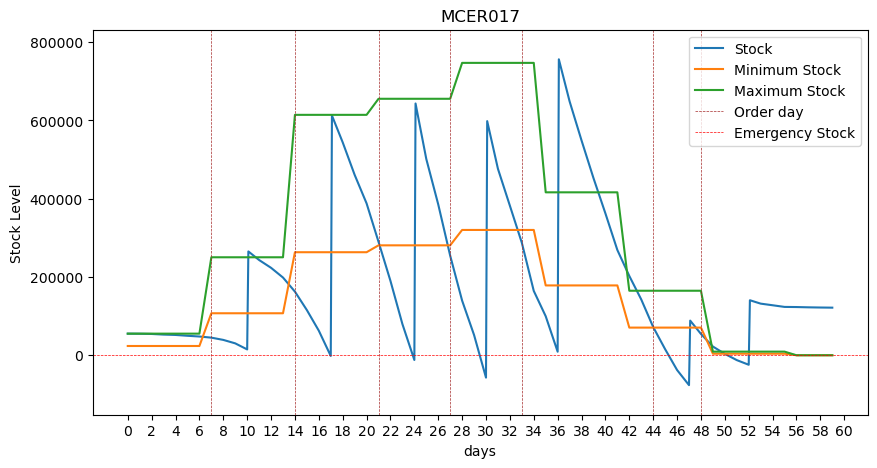

MCER018 delivery time: 2


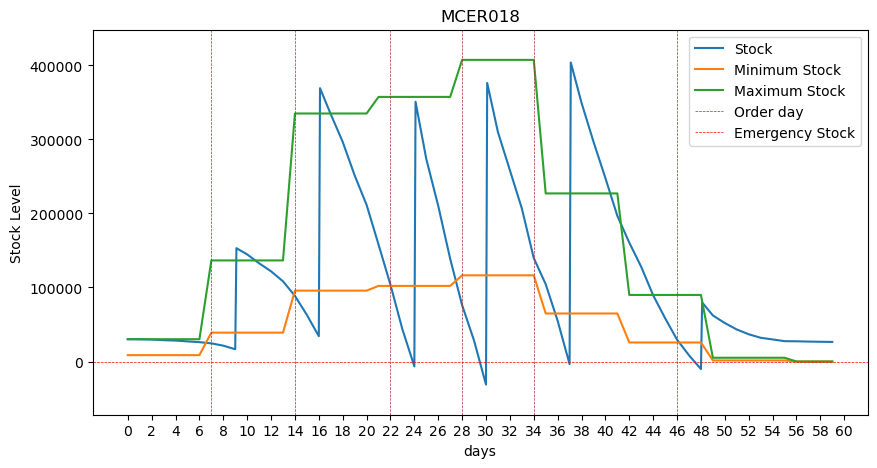

MCER020 delivery time: 1


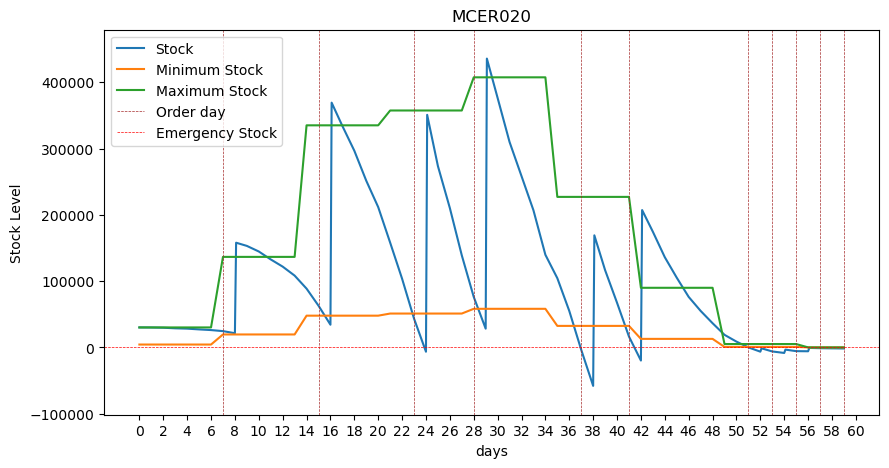

MCER021 delivery time: 5


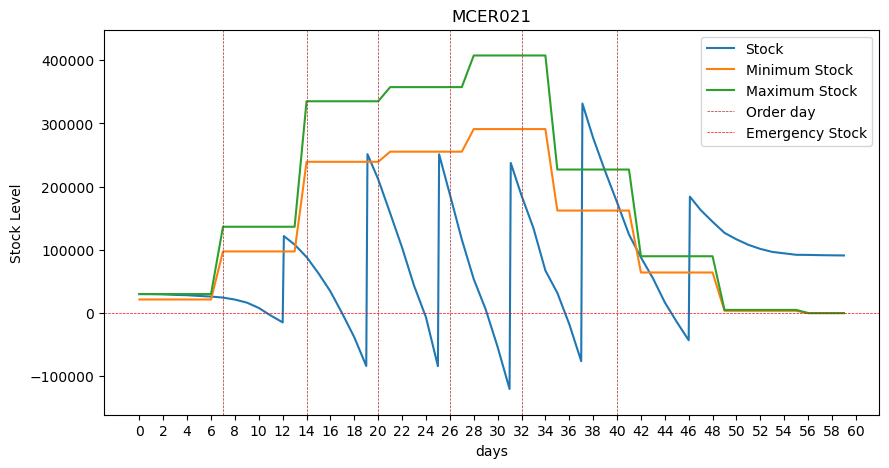

MCER022 delivery time: 1


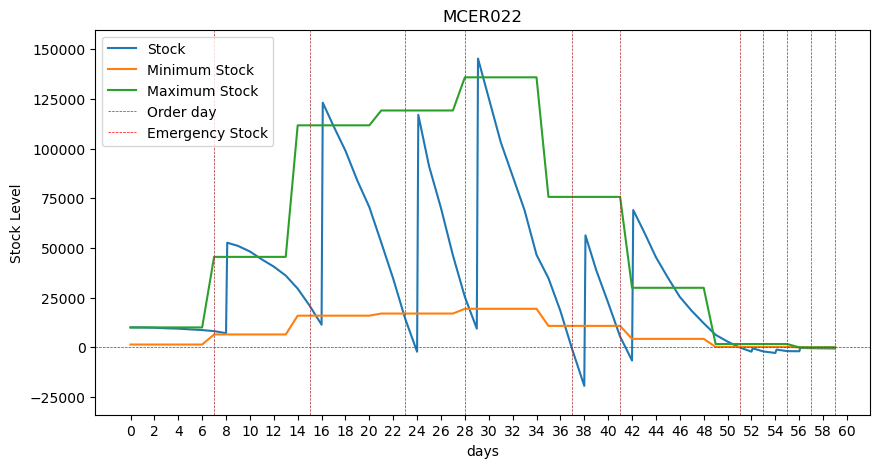

MCER026 delivery time: 3


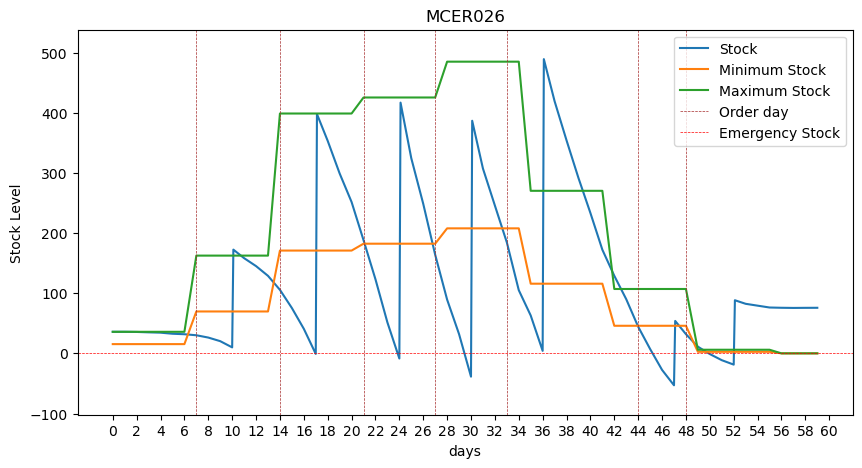

MCER027 delivery time: 5


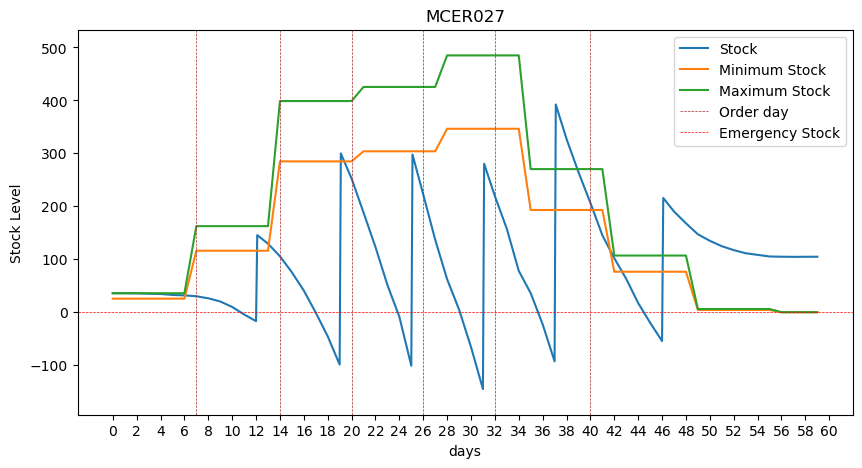

MCER028 delivery time: 3


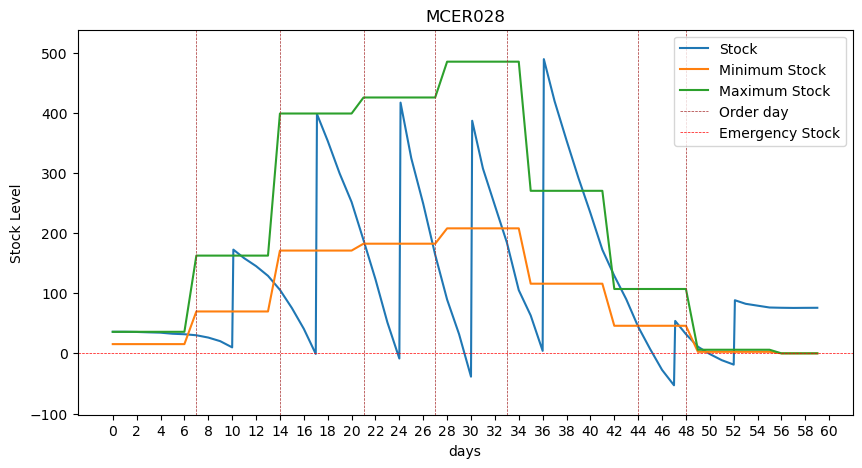

MCER029 delivery time: 3


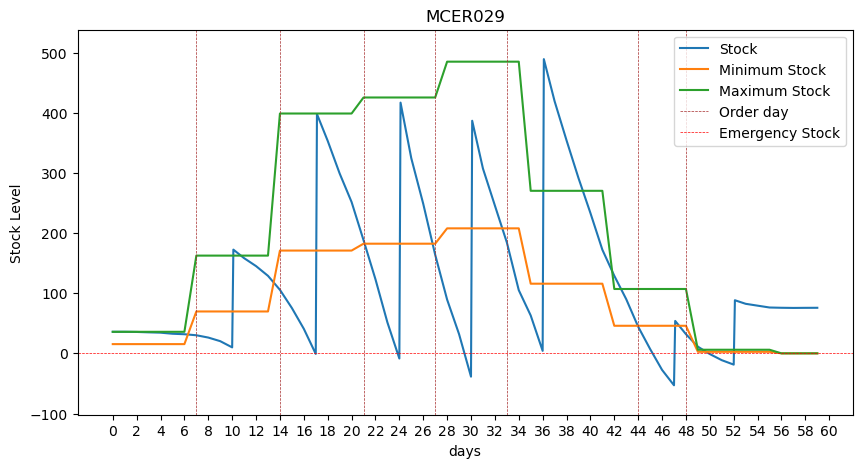

MCER030 delivery time: 3


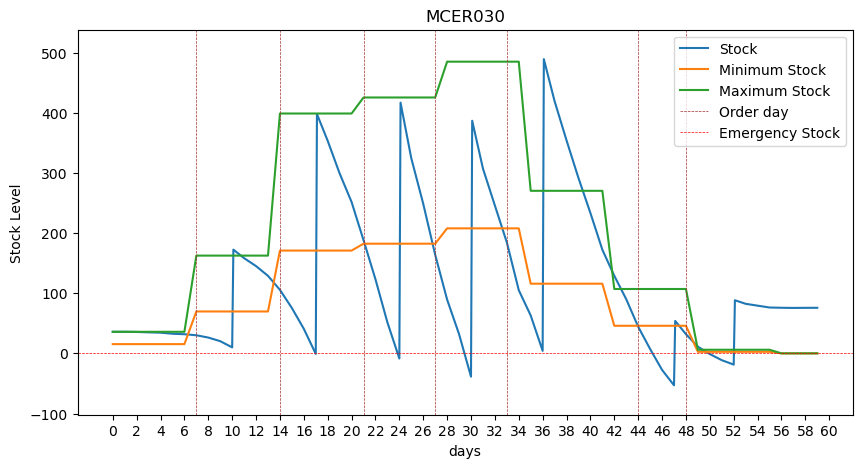

MCER031 delivery time: 4


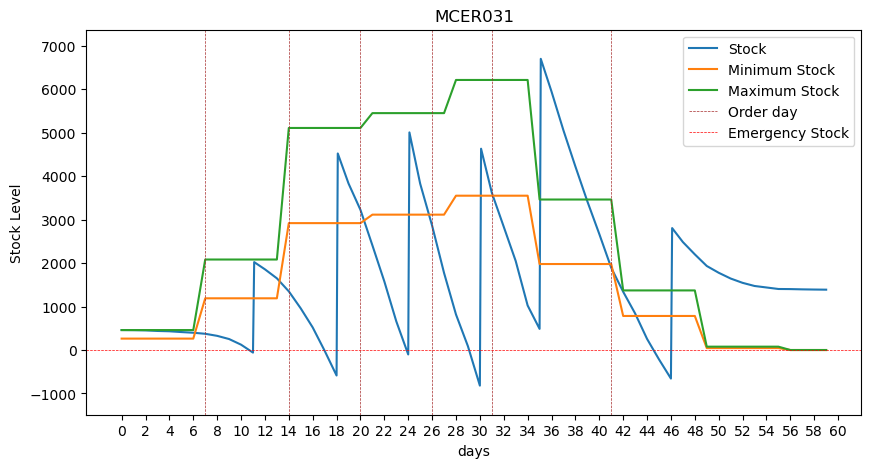

MCER032 delivery time: 1


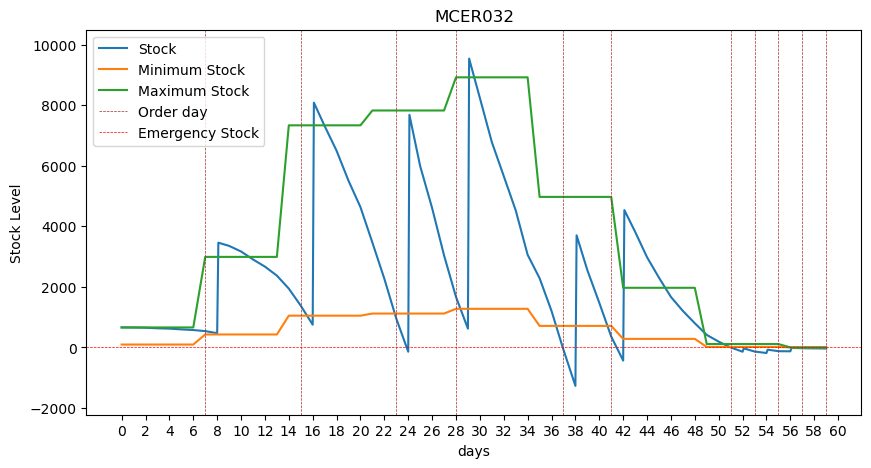

MCER033 delivery time: 5


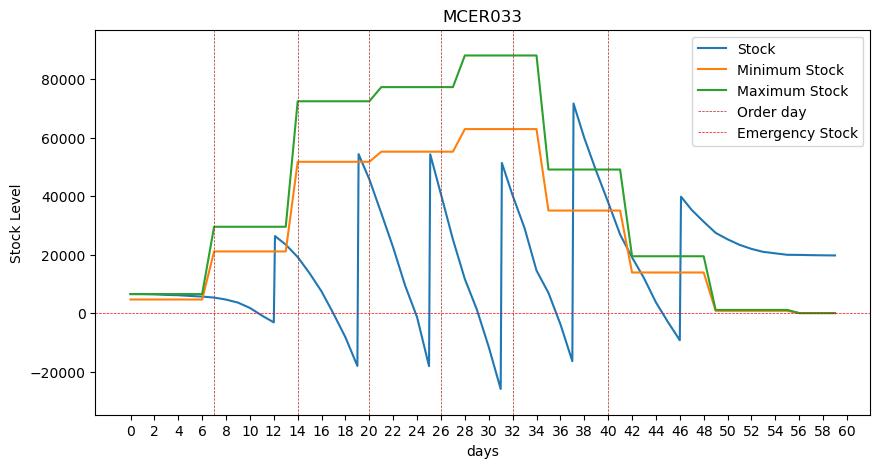

MCER034 delivery time: 5


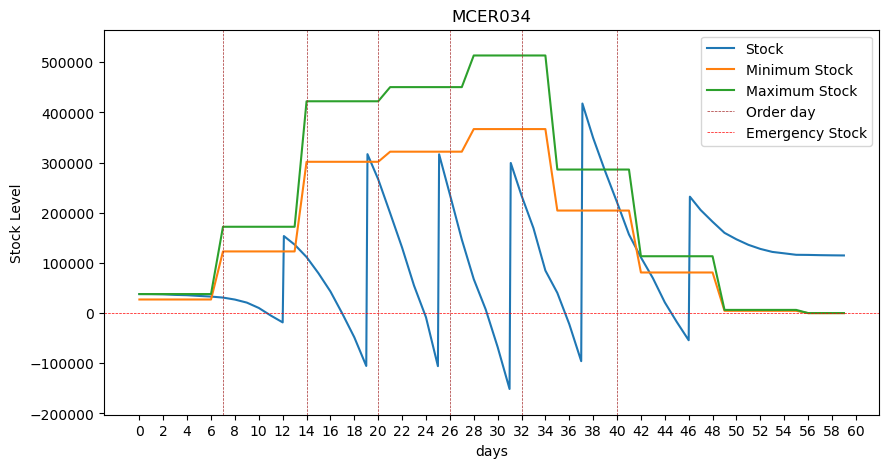

MCER035 delivery time: 2


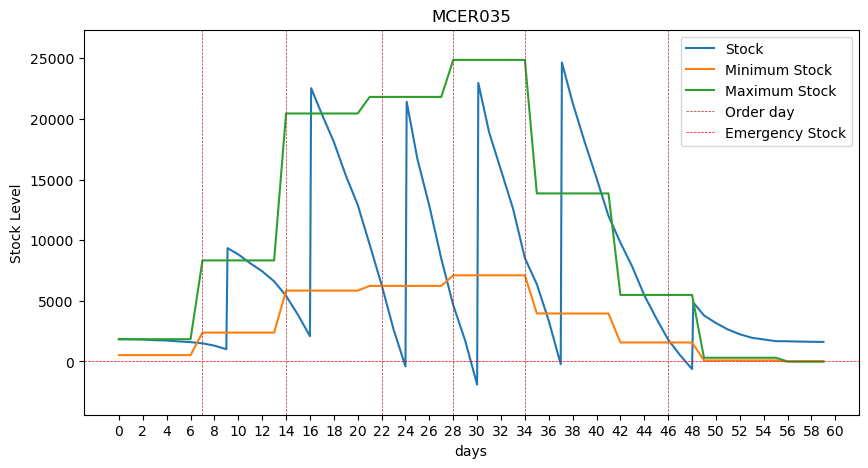

MCER036 delivery time: 2


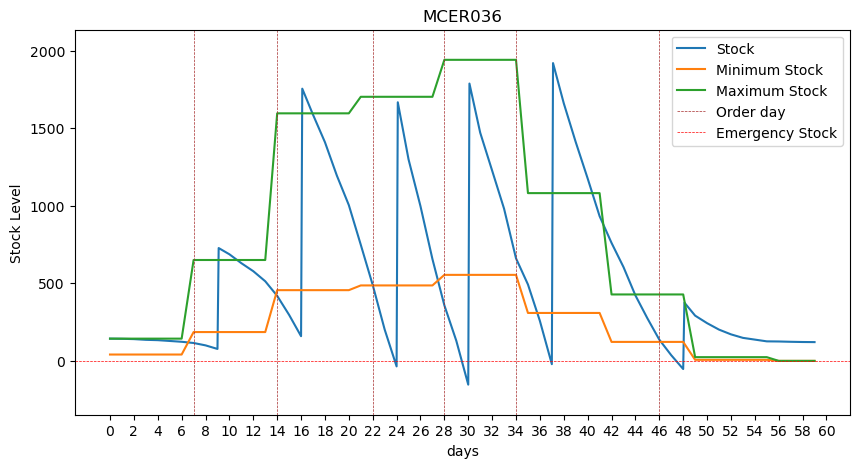

MCER037 delivery time: 1


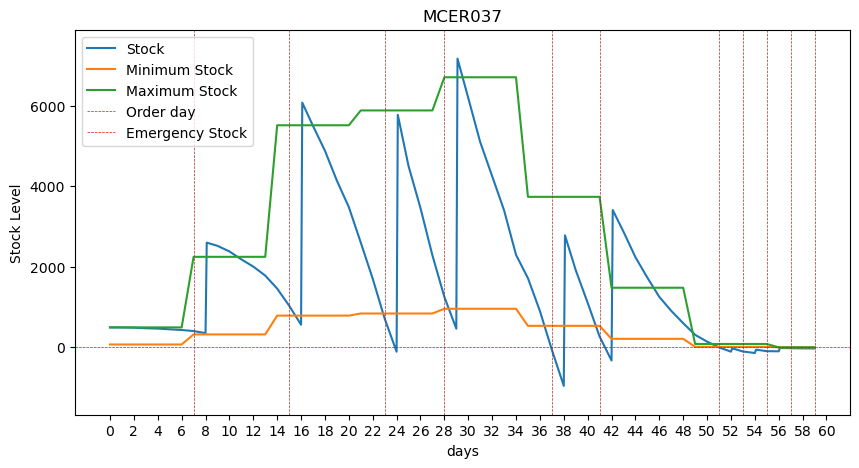

MCER038 delivery time: 3


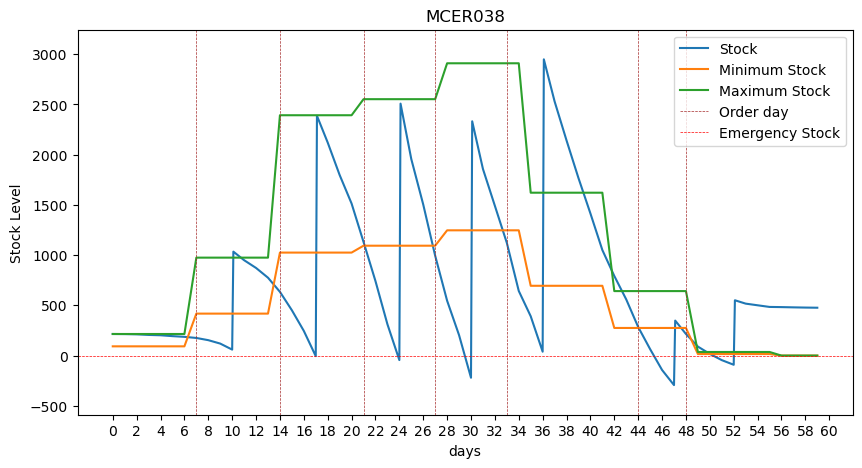

MCER039 delivery time: 2


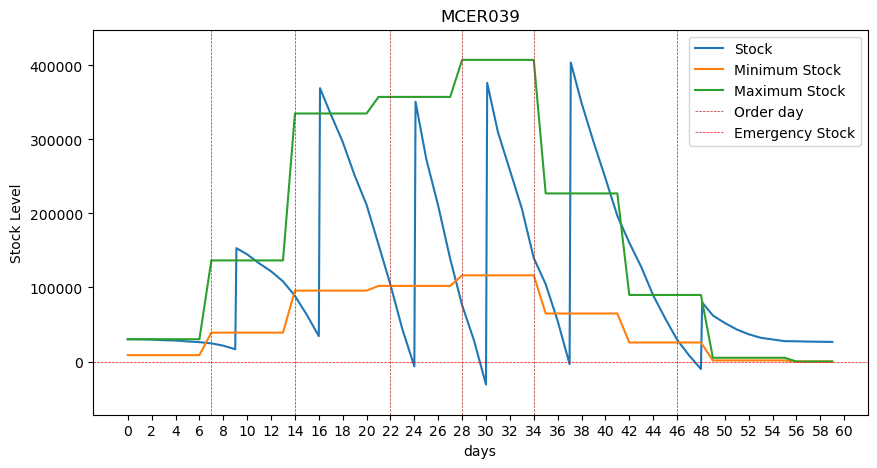

MCER040 delivery time: 4


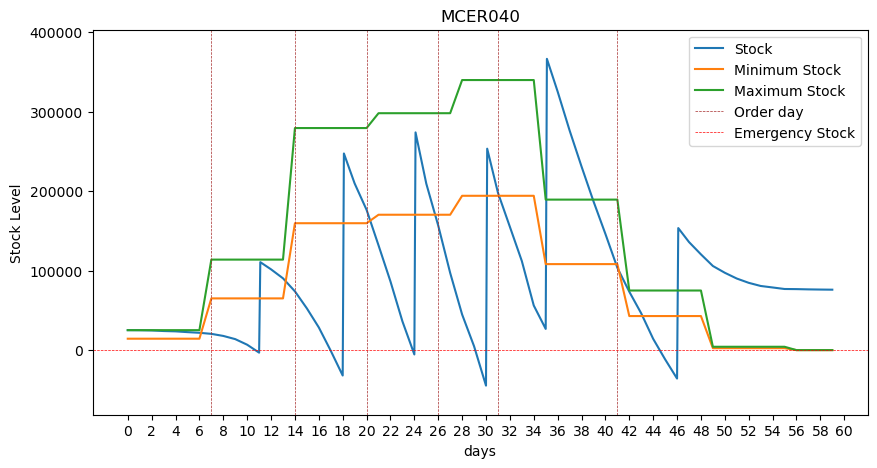

MCER041 delivery time: 5


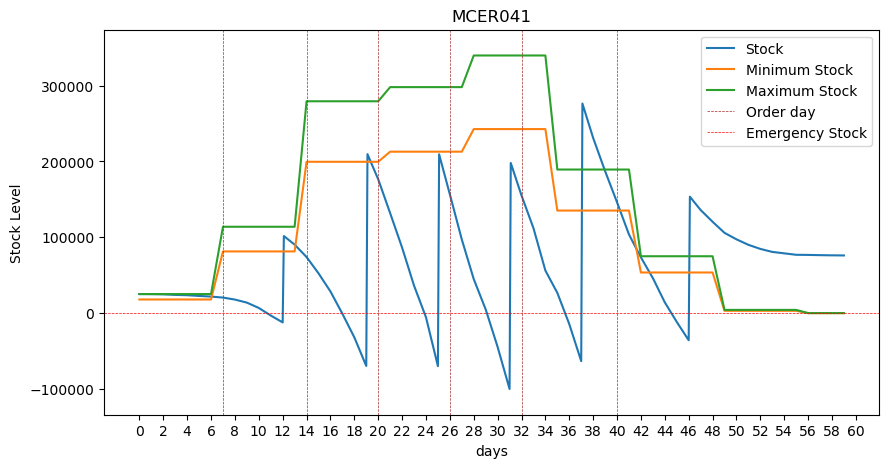

MCER043 delivery time: 2


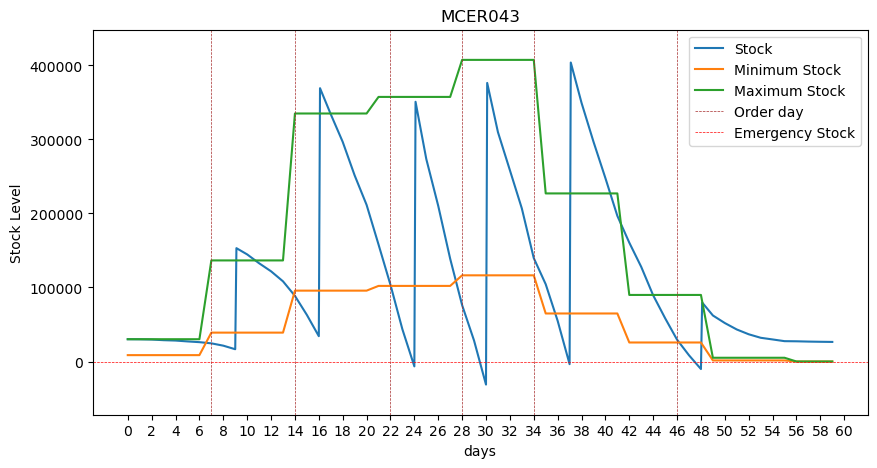

MCER046 delivery time: 2


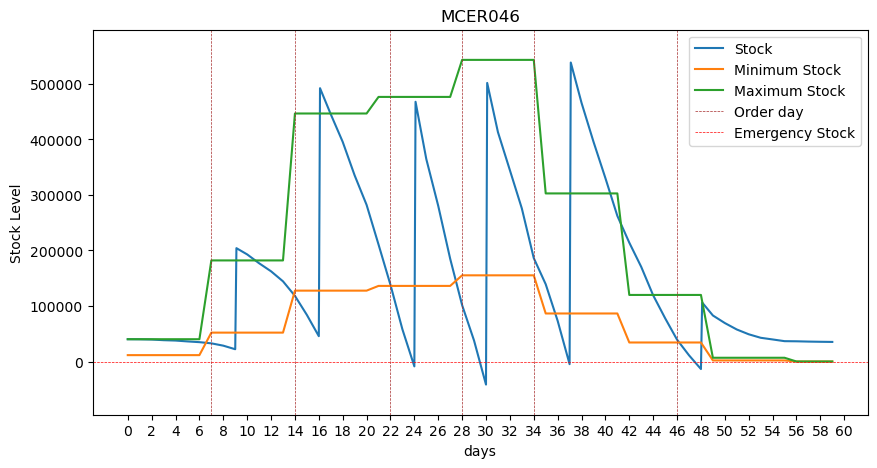

MCER047 delivery time: 2


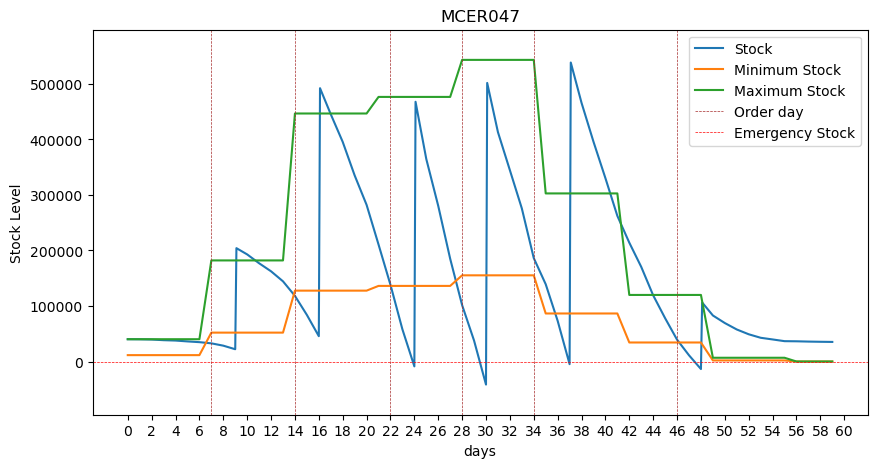

MCER051 delivery time: 2


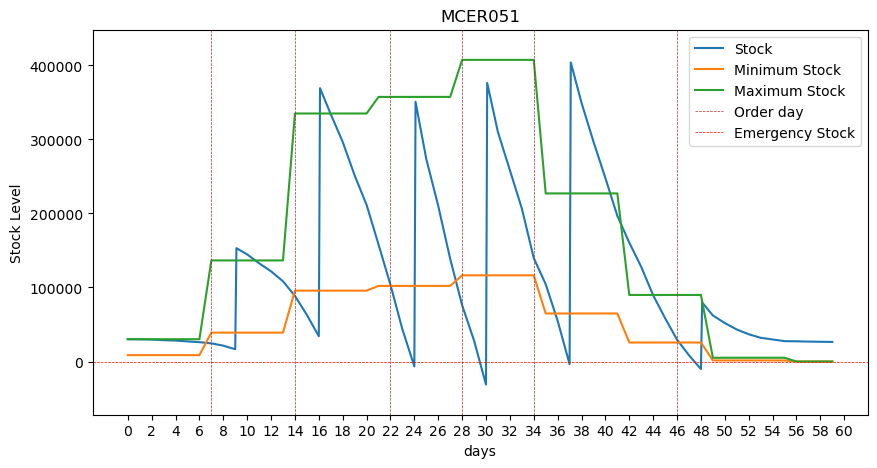

MCER057 delivery time: 5


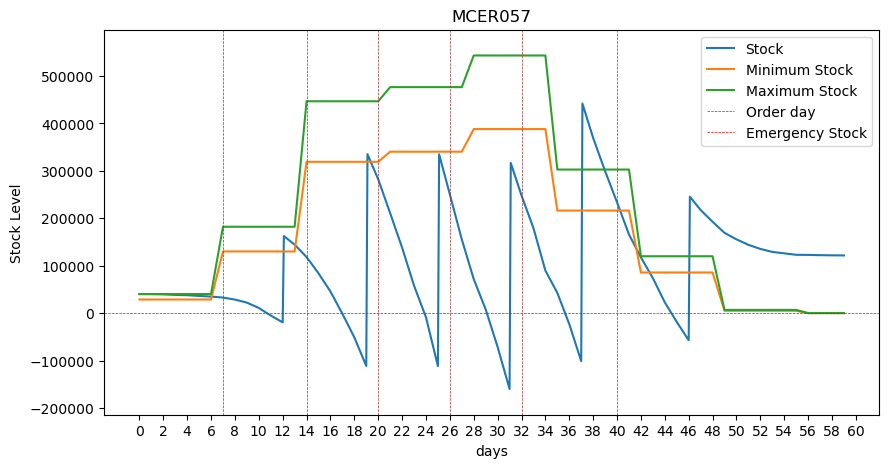

MCER067 delivery time: 2


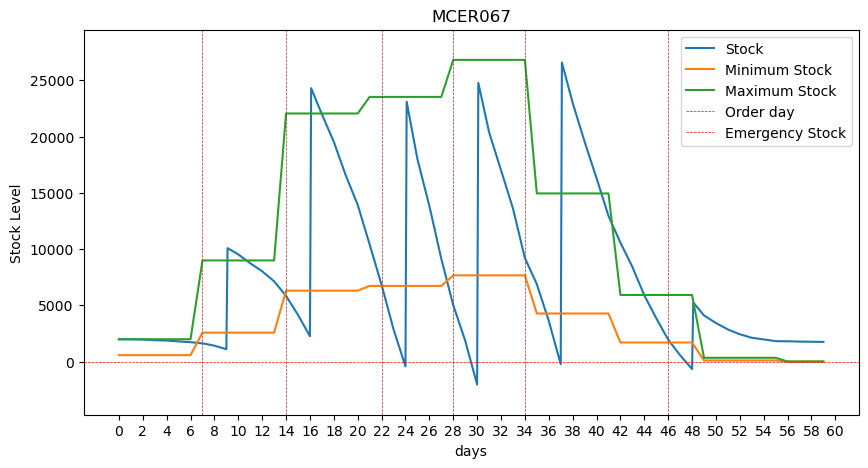

In [39]:
for material in packing:
    print(f"{material.name} delivery time: {material.delivery_time}")

    epsilon = 0.1

    x_stock = []
    y_stock = []

    for i in range(len(material.history["stock"])):
        x_stock.append(i)
        y_stock.append(material.history["stock"][i])

        if material.history["arrived_stock"][i] is not None:
            x_stock.append(i + epsilon)
            y_stock.append(material.history["arrived_stock"][i] + material.history["stock"][i])
    

    # Create a new figure for each material
    plt.figure()

    # Use len() to get the correct range for x-axis
    plt.plot(
        x_stock, y_stock, label="Stock"
    )
    plt.plot(
        range(len(material.history["minimum_stock"])),
        material.history["minimum_stock"],
        label="Minimum Stock",
    )
    plt.plot(
        range(len(material.history["maximum_stock"])),
        material.history["maximum_stock"],
        label="Maximum Stock",
    )
    days_ordered = order_day[material.name]
    for day in days_ordered:
        plt.axvline(
            x=day,
            color="brown",
            linewidth=0.5,
            linestyle="--",
            label="Order day" if day == days_ordered[0] else "",
        )

    plt.axhline(
        y=material.emergency_stock,
        color="red",
        linewidth=0.5,
        linestyle="--",
        label="Emergency Stock",
    )

    # Set title and labels
    plt.title(material.name)
    plt.xticks(even_days)
    plt.xlabel("days")  # Adjust label as necessary
    plt.ylabel("Stock Level")
    top_value = max(max(material.history["maximum_stock"]), max(y_stock))
    bot_value = min(min(material.history["minimum_stock"]), min(y_stock))
    plt.ylim(min(0, bot_value) - 0.1 * top_value, top_value * 1.1)
    plt.gcf().set_size_inches(10, 5)
    # plt.grid()

    # Show legend
    plt.legend()

    # Display the plot
    plt.show()

## Observaciones

El stock, casi en todos los ejemplos, toma valores negativos en algún punto. Esto muestra que la elección de stock de seguridad es crucial. Esta puede ser establecida de manera constante en el tiempo, lo que necesitaría un stock de seguridad más robusto, o de manera dinámica.

Se aprecia, además, que los materiales con *delivery time* pequeño, tienen mejores resultados: el stock de salida al terminar la temporada es menor y los stocks megativos son menores en magnitoud. Esto puede ser un resultado de usar el teorema de Taylor de orden 1 para predecir los valores futuros, mientras más lejana la predicción, peor será la predicción. Es decir, para mejorar los resultados, se puede reducir el *delivery time*